# 1. Multi-Armed Bandit

## Aufgabe 1.1: Der K-armige Bandit

Imports:

In [1]:
import random
import numpy as np

Create a distribution super class so that we can implement different kinds of distributions later on:

In [2]:
from abc import ABC, abstractmethod

class Distribution(ABC):
    
    @abstractmethod
    def __init__(self, *args):
        pass
    
    @abstractmethod
    def get_value(self):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def get_name(self):
        pass

    @abstractmethod
    def adapt(self):
        pass

Based on the super class, create two specific distributions, the Bernoulli and Normal Distribution:

In [15]:
class BernoulliDistribution(Distribution):
    def __init__(self, *args):
        if len(args) == 1:
            self.p = args[0]
        else:
            self.p = round(random.random(), 1)


    def get_value(self):
        """
        Returns 1 with probability p, which has been instantiated randomly
        """
        random_value = random.random()
        hit = random_value < self.p
        return float(hit)
    
    def get_params(self):
        return [self.p]
    
    def get_name(self):
        return 'Bernoulli'
    
    def adapt(self):
        self.p += np.random.normal(0.0, 0.5)

In [20]:
class NormalDistribution(Distribution):
    def __init__(self, *args):
        if len(args) == 2:
            self.mean = args[0]
            self.standard_deviation = args[1]
        else:
            self.mean = random.uniform(1, 5)
            self.standard_deviation = random.uniform(0.2, 3)

    def get_value(self):
        return np.random.normal(self.mean, self.standard_deviation)
    
    def get_params(self):
        return [self.mean, self.standard_deviation]
    
    def get_name(self):
        return 'Normal'
    
    def adapt(self):
        self.mean += np.random.normal(0.0, 0.5)
        self.standard_deviation += max(np.random.normal(0.0, 0.5), 0)


Now, create the bandit:

In [43]:
class kArmedBandit(object):
    
    def __init__(self, epsilon : float, arms : list, initial_Q_value = 0.0):
        
        self.initial_epsilon = epsilon
        self.arms = arms

        k = len(arms)

        self.Q = np.array([initial_Q_value] * k)
        self.N = np.zeros(k)

        self.G = 0
        self.regret = 0

        self.true_expected_values = [dist.get_params()[0] for dist in arms]
        self.a_star_index = np.argmax(self.true_expected_values)
        self.num_picks_a_star = 0

        print(f'Initialized bandit using {arms[0].get_name()} distribution, initial epsilon: {self.initial_epsilon}, true expected values: {np.round(self.true_expected_values, 1)}')

        self.first_pick = True

    def get_new_epsilon(self, num_picks : int):
        """
        Get a new value for epsilon. If you don't want to change epsilon, just type return self.initial_epsilon
        """
        #return self.initial_epsilon * np.exp(-0.005*num_picks)
        return self.initial_epsilon

    def pick(self, verbose = 0):
        
        # decide on explore vs exploit
        index = int(round(random.uniform(0, len(self.arms)-1), 0))

        epsilon = self.get_new_epsilon(np.sum(self.N))
        exploit = (random.random() > epsilon)
        if exploit and not self.first_pick:
            index = np.argmax(self.Q)

        self.first_pick = False

        # update percentual best hit
        if index == self.a_star_index:
            self.num_picks_a_star += 1

        # check whether we got a hit
        a = self.arms[index]
        R = a.get_value()
        
        # update cumulative metrics
        self.G += R
        self.regret += self.true_expected_values[self.a_star_index] - self.true_expected_values[index]

        # update Q
        self.N[index] += 1
        self.Q[index] = self.Q[index] + 1/self.N[index] * (R - self.Q[index])

        if verbose >= 1:
            print(f'Picked from arm {index} and got reward {R}, Exploited: {exploit}')
            if verbose >= 2:
                print(f'Q: {self.Q}, \nN: {self.N}')
            print('-'*10)


        return self.regret, self.G, self.num_picks_a_star / np.sum(self.N), self.G / np.sum(self.N)
    


Create a list of distributions, the bandits "arms":

In [21]:
k = 4
#arms = [NormalDistribution() for _ in range(k)]
arms = [NormalDistribution(2.62, 2.78),
        NormalDistribution(1.35, 0.93),
        NormalDistribution(4.62, 2.19),
        NormalDistribution(3.31, 1.28)]
epsilon_values = [0.01, 0.1, 0.2]

Now create the bandit(s) with the before specified epsilon values and let them pick:

In [ ]:
bandits = [kArmedBandit(epsilon, arms, 0.0) for epsilon in epsilon_values]

num_rolls = 1000

averaged_cumulative_regret = []
averaged_cumulative_reward = []
averaged_percentual_best_pick = []

num_runs = 1

for i in range(num_runs):
    cumulative_regret = [[] for _ in bandits]
    cumulative_reward = [[] for _ in bandits]
    percentual_best_pick = [[] for _ in bandits]

    for _ in range(num_rolls):
        for bandit_index in range(len(bandits)):
            bandit = bandits[bandit_index]
            regret, G, current_percentual_best_pick, avg_reward = bandit.pick(verbose = 0)
            
            cumulative_regret[bandit_index].append(regret)
            cumulative_reward[bandit_index].append(G)
            percentual_best_pick[bandit_index].append(current_percentual_best_pick)
    
    averaged_cumulative_regret.append(cumulative_regret)
    averaged_cumulative_reward.append(cumulative_reward)
    averaged_percentual_best_pick.append(percentual_best_pick)


averaged_cumulative_regret = np.average(averaged_cumulative_regret, axis=0)
averaged_cumulative_reward = np.average(averaged_cumulative_reward, axis=0)
averaged_percentual_best_pick = np.average(averaged_percentual_best_pick, axis=0)

Plot the results:

In [ ]:
import matplotlib.pyplot as plt

t = np.linspace(0, num_rolls, num_rolls)

fig, ax = plt.subplots(3, figsize=(15,10))

for bandit_index in range(len(bandits)):
    ax[0].plot(t, averaged_cumulative_reward[bandit_index], label = f'Epsilon = {epsilon_values[bandit_index]}')
    ax[1].plot(t, averaged_cumulative_regret[bandit_index], label = f'Epsilon = {epsilon_values[bandit_index]}')
    ax[2].plot(t, averaged_percentual_best_pick[bandit_index], label = f'Epsilon = {epsilon_values[bandit_index]}')

ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Cumulative Reward')
ax[0].legend()

ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Cumulative Regret')
ax[1].legend()

ax[2].set_xlabel('Steps')
ax[2].set_ylabel('Percentual best pick')
ax[2].legend()


## Aufgabe 1.2: Nicht-Stationärer Bandit

Ziel ist es, den oben dargestellten Banditen-Algorithmus so anzupassen, dass er auf das nicht-stationäre Banditenproblem anwendbar ist. Das nicht-stationäre Problem meint, dass sich die Wahrscheinlichkeitsverteilungen der einzelnen Möglkichkeiten über die Zeit ändern können. Da die oben aufgeführten Klassen zur Modellierung der Wahrscheinlichkeitsverteilungen bereits eine Methode zur Veränderung bereitstellen, können diese Klassen hier weiterverwendet werden, nur der Bandit muss angepasst werden, um die Veränderunng der Verteilungen zu triggern.

In [22]:
class NSkArmedBandit(object):
    
    def __init__(self, epsilon : float, arms : list, initial_Q_value = 0.0, change_interval = 5):
        
        self.initial_epsilon = epsilon
        self.arms = arms

        k = len(arms)

        self.Q = np.array([initial_Q_value] * k)
        self.N = np.zeros(k)

        self.G = 0
        self.regret = 0

        self.true_expected_values = [dist.get_params()[0] for dist in arms]
        self.a_star_index = np.argmax(self.true_expected_values)
        self.num_picks_a_star = 0

        print(f'Initialized bandit using {arms[0].get_name()} distribution, initial epsilon: {self.initial_epsilon}, true expected values: {np.round(self.true_expected_values, 1)}')

        self.first_pick = True
        self.change_interval = change_interval

    def update_a_star_index(self):
        self.true_expected_values = [dist.get_params()[0] for dist in self.arms]
        self.a_star_index = np.argmax(self.true_expected_values)

    def pick(self, verbose = 0):
        
        # decide on explore vs exploit
        index = int(round(random.uniform(0, len(self.arms)-1), 0))

        epsilon = self.initial_epsilon
        exploit = (random.random() > epsilon)
        if exploit and not self.first_pick:
            index = np.argmax(self.Q)

        self.first_pick = False

        # update percentual best hit
        if index == self.a_star_index:
            self.num_picks_a_star += 1

        # check whether we got a hit
        a = self.arms[index]
        R = a.get_value()
        
        # update cumulative metrics
        self.G += R
        self.regret += self.true_expected_values[self.a_star_index] - self.true_expected_values[index]

        # update Q
        self.N[index] += 1
        self.Q[index] = self.Q[index] + 1/self.N[index] * (R - self.Q[index])

        a_star_index_before_update = self.a_star_index
        # model the non-stationarity
        if np.sum(self.N) % self.change_interval == 0:
            if verbose == 1:
                print('Changing probability distributions...')
            for arm in self.arms:
                arm.adapt()
            self.update_a_star_index()

        # optional print statements
        if verbose >= 1:
            print(f'Picked from arm {index} and got reward {R}, Exploited: {exploit}')
            if verbose >= 2:
                print(f'Q: {self.Q}, \nN: {self.N}')
            print('-'*10)


        return self.N, R, self.G, index, a_star_index_before_update

Execute the algorithm:

In [32]:
non_stationary_bandit = NSkArmedBandit(epsilon=0.1, arms=arms, initial_Q_value=0.0, change_interval=5)

num_rolls = 1000

relative_picks = [[] for _ in range(k)]
rewards = []
cumulative_rewards = []
best_index = []
picked_index = []

for _ in range(num_rolls):
    N, R, G, index, a_star_index = non_stationary_bandit.pick(verbose = 0)
    
    total_num_picks = np.sum(N)
    for num_picks_index in range(len(N)):
        relative_picks_per_index = N[num_picks_index] / total_num_picks
        relative_picks[num_picks_index].append(relative_picks_per_index)

    rewards.append(R)
    cumulative_rewards.append(G)
    best_index.append(a_star_index)
    picked_index.append(index)

Initialized bandit using Normal distribution, initial epsilon: 0.1, true expected values: [19.8  5.1 26.2 22.2]


Visualize the results:

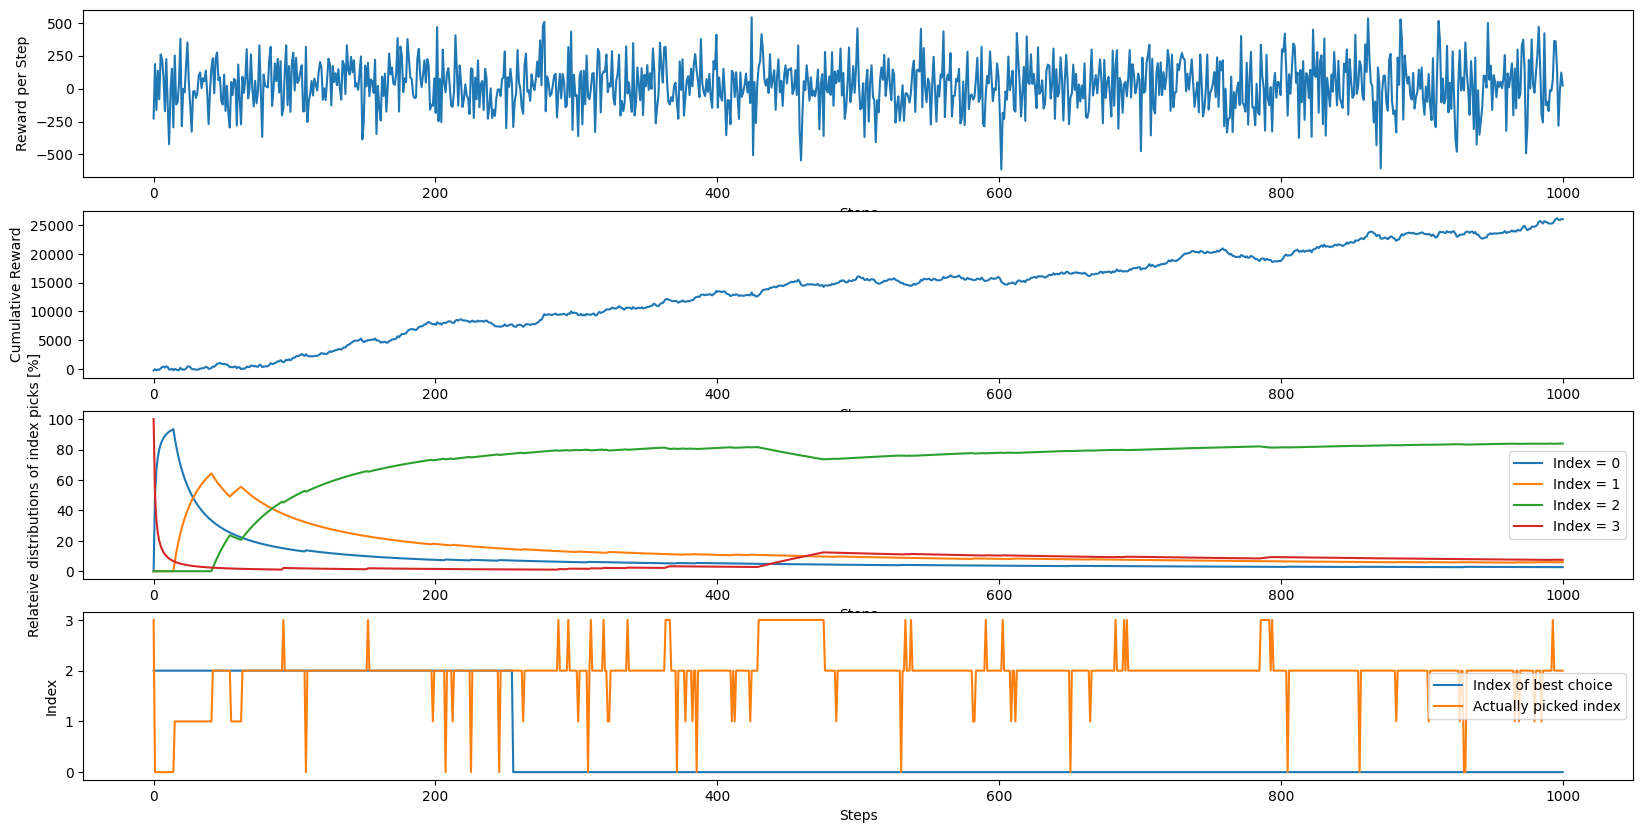

In [34]:
import matplotlib.pyplot as plt

t = np.linspace(0, num_rolls, num_rolls)

fig, ax = plt.subplots(4, figsize=(20,10))

ax[0].plot(t, rewards)
ax[1].plot(t, cumulative_rewards)

for index in range(len(relative_picks)):
    picks_per_index = np.multiply(relative_picks[index], 100)
    ax[2].plot(t, picks_per_index, label = f'Index = {index}')

ax[3].plot(t, best_index, label = 'Index of best choice')
ax[3].plot(t, picked_index, label = 'Actually picked index')

ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Reward per Step')

ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Cumulative Reward')

ax[2].set_xlabel('Steps')
ax[2].set_ylabel('Relateive distributions of index picks [%]')
ax[2].legend()

ax[3].set_xlabel('Steps')
ax[3].set_ylabel('Index')
ax[3].legend()
